In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

from datetime import datetime as dt
import itertools
from tqdm import tqdm
from scipy.stats import norm, t
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler,MinMaxScaler
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score,log_loss
# import lightgbm as lgb
import gc

from sklearn.model_selection import StratifiedKFold,KFold
from sklearn import metrics
import xgboost as xgb


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# ss

In [4]:
train_ori = pd.read_csv('/kaggle/input/airquoi/train.csv',parse_dates=['date'])
test_ori = pd.read_csv('/kaggle/input/airquoi/test.csv',parse_dates=['date'])
ss =pd.read_csv('/kaggle/input/airquoi/SampleSubmission.csv')

In [5]:
# a = train.site_latitude.unique()
def get_prev(df,shifts = 1,col = 'pm2_5'):
    df['shifted_'+str(shifts)] = df.shift(shifts)[col].values
    return df
def target_encode(df_train,df_test,target,groupss):
    groupss_target_mean = df_train.groupby(groupss)[target].mean()
    groupss_target_max = df_train.groupby(groupss)[target].max()
    groupss_target_min = df_train.groupby(groupss)[target].min()
    groupss_target_std = df_train.groupby(groupss)[target].std()
    groupss_target_median = df_train.groupby(groupss)[target].apply(lambda x : np.median(x))
    groupss_target_q95 = df_train.groupby(groupss)[target].apply(lambda x : np.quantile(x,0.95))
    groupss_target_q05 = df_train.groupby(groupss)[target].apply(lambda x : np.quantile(x,0.05))
    groupss_target_skew = df_train.groupby(groupss)[target].skew()
    groupss_target_kurt = df_train.groupby(groupss)[target].apply(lambda x : x.kurtosis())
    # groupss_target_mean = df_train.groupby(groupss)[target].mean()
    df_test[groupss+target+'enc'] = df_test[groupss].map(groupss_target_mean)
    df_test[groupss+target+'enc'].fillna((df_test[groupss+target+'enc'].mean()), inplace=True)
    df_test[groupss+target+'enc1'] = df_test[groupss].map(groupss_target_max)
    df_test[groupss+target+'enc1'].fillna((df_test[groupss+target+'enc1'].mean()), inplace=True)
    df_test[groupss+target+'enc2'] = df_test[groupss].map(groupss_target_min)
    df_test[groupss+target+'enc2'].fillna((df_test[groupss+target+'enc2'].mean()), inplace=True)
    df_test[groupss+target+'enc3'] = df_test[groupss].map(groupss_target_std)
    df_test[groupss+target+'enc3'].fillna((df_test[groupss+target+'enc3'].mean()), inplace=True)
    df_test[groupss+target+'enc4'] = df_test[groupss].map(groupss_target_median)
    df_test[groupss+target+'enc4'].fillna((df_test[groupss+target+'enc4'].mean()), inplace=True)
    df_test[groupss+target+'enc5'] = df_test[groupss].map(groupss_target_q95)
    df_test[groupss+target+'enc5'].fillna((df_test[groupss+target+'enc5'].mean()), inplace=True)
    df_test[groupss+target+'enc6'] = df_test[groupss].map(groupss_target_q05)
    df_test[groupss+target+'enc6'].fillna((df_test[groupss+target+'enc6'].mean()), inplace=True)
    df_test[groupss+target+'enc7'] = df_test[groupss].map(groupss_target_skew)
    df_test[groupss+target+'enc7'].fillna((df_test[groupss+target+'enc7'].mean()), inplace=True)
    df_test[groupss+target+'enc8'] = df_test[groupss].map(groupss_target_kurt)
    df_test[groupss+target+'enc8'].fillna((df_test[groupss+target+'enc8'].mean()), inplace=True)
    tmp =np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : x.skew())
        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc7'] = tmp
    tmp =np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : x.kurtosis())

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc8'] = tmp
    
    tmp =np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : np.quantile(x,0.05))

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc6'] = tmp
    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1991032)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : np.quantile(x,0.95))

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc5'] = tmp



    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1991035)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : np.median(x))

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc4'] = tmp



    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].mean()

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc'] = tmp



    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1991025)
    for idx_1, idx_2 in kf.split(df_train):
        target_max = df_train.iloc[idx_1].groupby(groupss)[target].max()

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_max)
    df_train[groupss+target+'enc1'] = tmp
    # from sklearn.model_selection import KFold/
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1990325)
    for idx_1, idx_2 in kf.split(df_train):
        target_min = df_train.iloc[idx_1].groupby(groupss)[target].min()

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_min)
    df_train[groupss+target+'enc2'] = tmp
    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_std = df_train.iloc[idx_1].groupby(groupss)[target].std()

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_std)
    df_train[groupss+target+'enc3'] = tmp
    df_train[groupss+target+'enc'].fillna((df_train[groupss+target+'enc'].mean()), inplace=True)
    df_train[groupss+target+'enc1'].fillna((df_train[groupss+target+'enc1'].mean()), inplace=True)
    df_train[groupss+target+'enc2'].fillna((df_train[groupss+target+'enc2'].mean()), inplace=True)
    df_train[groupss+target+'enc3'].fillna((df_train[groupss+target+'enc3'].mean()), inplace=True)
    df_train[groupss+target+'enc4'].fillna((df_train[groupss+target+'enc4'].mean()), inplace=True)
    df_train[groupss+target+'enc5'].fillna((df_train[groupss+target+'enc5'].mean()), inplace=True)
    df_train[groupss+target+'enc6'].fillna((df_train[groupss+target+'enc6'].mean()), inplace=True)
    return df_train, df_test


In [8]:
# train.site_latitude.astype('str')

In [9]:
def preprocess(train,test):
    le = LabelEncoder()
    train['Train']=1
    test['Train']=0
#     home_teams=train['Home Team'].unique()
    all_data=pd.concat([train,test])
    all_data['month'] = all_data.date.dt.month
    all_data['year'] = all_data.date.dt.year
    all_data['day'] = all_data.date.dt.day
    all_data['week'] = all_data.date.dt.week
    all_data['dow'] = all_data.date.dt.dayofweek
    all_data['woy'] = all_data.date.dt.weekofyear
#     all_data[['site_latitude','site_longitude']] =  all_data[['site_latitude','site_longitude']] .round(5)
#     for c in all_data.drop(['date','pm2_5'], axis = 1).select_dtypes(exclude = 'object').columns:
#         all_data[c] = all_data[c].fillna(all_data[c].min()-1)
#     all_data['rel_date'] = all_data.groupby('site_latitude').apply(lambda x : ((x.date-x.date.min())/ np.timedelta64(1, 'D')).astype('int') +1).reset_index()['date']

    all_data['device'] = le.fit_transform(all_data['device'].values.reshape(-1,1))
    le = LabelEncoder()
#     all_data['site_code'] = le.fit_transform(all_data.site_latitude.astype('str').values.reshape(-1,1))
#     all_data = get_prev(all_data.reset_index(drop = True),shifts = 1,col = 'pm2_5')
    train = all_data.loc[all_data.Train == 1].reset_index(drop = True)
    test = all_data.loc[all_data.Train == 0].reset_index(drop = True)
#     train, test = interpol(train,test)
#     train,test = target_encode(train,test,target = 'pm2_5',groupss = 'site_latitude')
    return train, test
def _get_X_Y_DF_from_CV(train_X, train_Y, train_index, validation_index):
        X_train, X_validation = (
            train_X.iloc[train_index],
            train_X.iloc[validation_index],
        )
        y_train, y_validation = (
            train_Y.iloc[train_index],
            train_Y.iloc[validation_index],
        )
        return X_train, X_validation, y_train, y_validation
    

def train_lgb(X,y,test_data,params,seed_lgb,shuffle_lgb):
    features_importance= pd.DataFrame({'Feature':[], 'Importance':[]})
    models =[]
    train_X = X.copy()
    train_Y = y.copy()
    test_X = test_data.copy()
    print(f"Shape of train_X : {train_X.shape}, test_X: {test_X.shape}, train_Y: {train_Y.shape}")

    predictors = list(train_X.columns)
    # print(f"List of features to be used {list(predictors)}")

    # Selecting n_splits to be 3, since class 42 has 
    # just 3 instances
    kf = KFold(random_state=seed_lgb,n_splits=K_FOLDS, shuffle=shuffle_lgb)
    y_oof_lgb = np.zeros(shape=(len(train_X),))
    y_predicted_lgb = np.zeros(shape=(len(test_X),))
    cv_scores = []
    fold = 0
    n_folds = kf.get_n_splits()
    for train_index, validation_index in kf.split(X=train_X, y=train_Y):
        fold += 1
        print(f"fold {fold} of {n_folds}")

        X_train, X_validation, y_train, y_validation = _get_X_Y_DF_from_CV(
            train_X, train_Y, train_index, validation_index
        )

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_validation, y_validation, reference=lgb_train)

        model = lgb.train(
            lgb_params,
            lgb_train,
            valid_sets=[lgb_train, lgb_eval],
            verbose_eval=100,
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            num_boost_round=N_ESTIMATORS,
            feature_name=predictors,
            categorical_feature="auto",
        )
        del lgb_train, lgb_eval, train_index, X_train, y_train
        gc.collect()

        y_oof_lgb[validation_index] = model.predict(
            X_validation, num_iteration=model.best_iteration
        )

        y_predicted_lgb += model.predict(
            test_data.values, num_iteration=model.best_iteration
        )
        fold_importance_df= pd.DataFrame({'Feature':[], 'Importance':[]})
        fold_importance_df['Feature']= predictors
        fold_importance_df['Importance']= model.feature_importance()
        fold_importance_df["fold"] = fold + 1
        features_importance = pd.concat([features_importance, fold_importance_df], axis=0)
        models.append(model)

        best_iteration = model.best_iteration
        print(f"Best number of iterations for fold {fold} is: {best_iteration}")

        cv_oof_score = metrics.mean_absolute_error(y_validation, y_oof_lgb[validation_index])
        cv_scores.append(cv_oof_score)
        print(f"CV OOF Score for fold {fold} is {cv_oof_score}")

        del validation_index, X_validation, y_validation
        gc.collect()

    y_predicted_lgb /= n_folds
    oof_score = round(metrics.mean_absolute_error(train_Y, y_oof_lgb), 5)
    avg_cv_scores = round(sum(cv_scores) / len(cv_scores), 5)
    std_cv_scores = round(np.array(cv_scores).std(), 5)
    return y_predicted_lgb,models,y_oof_lgb,oof_score,features_importance
def train_catbo(train_X, train_Y,test_X,params,seed_cat,shuffle_cat):
# model.fit(train_pool,plot=True,eval_set=test_pool)
    kf = KFold(random_state=seed_cat,n_splits=K_FOLDS, shuffle=shuffle_cat)
    y_oof = np.zeros(shape=(len(train_X),))
    y_predicted = np.zeros(shape=(len(test_X),))
    cv_scores = []
    models = []
    fold = 0
    n_folds = kf.get_n_splits()
    for train_index, validation_index in kf.split(X=train_X, y=train_Y):
        fold += 1
        print(f"fold {fold} of {n_folds}")

        X_train, X_validation, y_train, y_validation = _get_X_Y_DF_from_CV(
            train_X, train_Y, train_index, validation_index
        )

        train_pool = Pool(data=X_train, label=y_train)
        eval_pool = Pool(data=X_validation, label=y_validation.values) 
        model = CatBoostRegressor(**params)
        model.fit(train_pool,plot=True,eval_set=eval_pool)
        del train_index, X_train, y_train
        gc.collect()
        models.append(model)
        y_oof[validation_index] = model.predict(
            X_validation )

        y_predicted += model.predict(
            test_X.values
        )

    #     best_iteration = model.best_iteration
    #     print(f"Best number of iterations for fold {fold} is: {best_iteration}")

        cv_oof_score = metrics.mean_absolute_error(y_validation, y_oof[validation_index])
        cv_scores.append(cv_oof_score)
        print(f"CV OOF Score for fold {fold} is {cv_oof_score}")

        del validation_index, X_validation, y_validation
        gc.collect()

    y_predicted /= n_folds
    oof_score = round(metrics.mean_absolute_error(train_Y, y_oof), 5)
    avg_cv_scores = round(sum(cv_scores) / len(cv_scores), 5)
    std_cv_scores = round(np.array(cv_scores).std(), 5)
    return y_predicted,models,y_oof,oof_score
def train_xgb(X,y,test_data,params,num_iter=1500,es = 100,ve = 100,seed_xgb=42,shuffle_xgb=True):
    features = X.columns
    X = X.values
    # y = train['target'].values
    y_oof = np.zeros(shape=(len(X),))
    y_predicted = np.zeros(shape=(len(test_data), ))
    cv_scores = []
    models = []
    kf = KFold(random_state=seed_xgb,n_splits=K_FOLDS, shuffle=shuffle_xgb)

    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        print(' xgb kfold: {}  of  {} : '.format(i+1, K_FOLDS ))
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        d_train = xgb.DMatrix(X_train, y_train) 
        d_valid = xgb.DMatrix(X_valid, y_valid) 
        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        xgb_model = xgb.train(params, d_train, num_iter, watchlist,
                              early_stopping_rounds=es, 
                            verbose_eval=ve)
        models.append(xgb_model)
        y_oof[test_index] = xgb_model.predict(xgb.DMatrix(X_valid), 
                            ntree_limit=xgb_model.best_ntree_limit)
        y_predicted += xgb_model.predict(xgb.DMatrix(test_data[features].values), 
                            ntree_limit=xgb_model.best_ntree_limit) 
        
        cv_oof_score = metrics.mean_absolute_error(y_valid, y_oof[test_index])
        cv_scores.append(cv_oof_score)
        print(f"CV OOF Score for fold {i+1} is {cv_oof_score}")

#         del validation_index, X_validation, y_validation
#         gc.collect()

    y_predicted /= K_FOLDS
    oof_score = round(metrics.mean_absolute_error(y, y_oof), 5)
    avg_cv_scores = round(sum(cv_scores) / len(cv_scores), 5)
    std_cv_scores = round(np.array(cv_scores).std(), 5)
    return y_predicted,models,y_oof,oof_score 
def train_keras(X,train,test_data):
#     train ['Original_score'] = le.inverse_transform(train.Score)
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     X_scaled = scaler.fit_transform(X)
#     X_scaled = pd.DataFrame(X_scaled)
#     Y = pd.get_dummies(train['Original_score'])
    X_scaled = X.values
    Y = Y.values
    inp = len(X.columns)
    y_oof = np.zeros(shape=(len(X), NUM_CLASSES))
    y_predicted = np.zeros(shape=(len(test_data), NUM_CLASSES))
    cv_scores = []
    models = []
    kf = KFold(random_state=SEED,n_splits=K_FOLDS, shuffle=True)
    for i, (train_index, test_index) in enumerate(kf.split(X_scaled, Y)):
        print(' keras kfold: {}  of  {} : '.format(i+1, K_FOLDS ))
        X_train, X_valid = X_scaled[train_index], X_scaled[test_index]
        y_train, y_valid = Y[train_index], Y[test_index]
#         np.random.seed(SEED)
        my_model = baseline_model(inp)
        my_model.fit(X_train, y_train,
                     validation_data=(X_valid, y_valid),
                     epochs=1000,
                     callbacks=[EarlyStopping(patience=20)],
                     verbose=0)
        
        models.append(my_model)
        y_oof[test_index] = my_model.predict(X_valid)
        y_predicted += my_model.predict(test_data.values) 
        del my_model
        gc.collect()
        cv_oof_score = metrics.log_loss(y_valid, y_oof[test_index])
        cv_scores.append(cv_oof_score)
        print(f"CV OOF Score for fold {i+1} is {cv_oof_score}")

#         del validation_index, X_validation, y_validation
#         gc.collect()

    y_predicted /= K_FOLDS
    oof_score = round(metrics.log_loss(y, y_oof), 5)
    avg_cv_scores = round(sum(cv_scores) / len(cv_scores), 5)
    std_cv_scores = round(np.array(cv_scores).std(), 5)
    return y_predicted,models,y_oof,oof_score 
from matplotlib import pyplot as plt
# Keras imports
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import EarlyStopping
import os 
import random
import numpy as np 

DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# tensorflow random seed 
import tensorflow as tf 
def seedTF(seed=DEFAULT_RANDOM_SEED):
    tf.random.set_seed(seed)
    
# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTF(seed)
    seedTorch(seed)
seedEverything(42)
seed = 42

def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:10].index
    best_features = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:50]
    best_features.reset_index(inplace=True)
    print(best_features.dtypes)
    plt.figure(figsize=(8, 10))
    sns.barplot(x="Importance", y="Feature", data=best_features)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
def preds_to_sub(test,preds,name = None,log = False):
    if log :
        test['pm2_5'] = np.exp(preds)
    else:
        test['pm2_5'] = preds
    sub = test[['ID','pm2_5']]
    if name:
        sub.to_csv(name+'.csv', index = False)
    return sub

# def preds_to_sub(test,le,y_predicted,save = False):
#     Test = test.copy()
#     cols=le.inverse_transform([*range(3)])
#     Test[cols]= y_predicted
#     submit = Test[["Game_ID",'Away win', 'Draw', 'Home Win']]
#     submit.drop_duplicates(subset = ["Game_ID"], inplace=True)
#     submit = submit.reset_index(drop=True)
#     if save:
#         submit.to_csv("submission_gbm15.csv", index=False)
#     return submit   

In [10]:
# sns.distplot(train['pm2_5'])
# train.loc[train.pm2_5 == train.pm2_5.max() ]
# plt.plot(train.loc[(train.site_latitude == 0.2182)& (train.site_longitude == 32.6176),'date'],
# train.loc[(train.site_latitude == 0.2182)& (train.site_longitude == 32.6176),'pm2_5'])
# test.date.min()
# test.device.isin(train.device.unique()).all()
from sklearn.preprocessing import LabelEncoder
train,test = preprocess(train_ori,test_ori)
# for c in train.select_dtypes(exclude = 'object').columns:
#     print(train[c].min())
#      all_data[c] = all_data[c].fillna(all_data[c].min()-1)

In [220]:
def get_dist(all_data, i,j):
    return np.sqrt((all_data.loc[all_data.site_code == i,'site_latitude'].unique()[0]- all_data.loc[all_data.site_code == j,'site_latitude'].unique()[0])**2 + (all_data.loc[all_data.site_code == i,'site_longitude'].unique()[0]- all_data.loc[all_data.site_code == j,'site_longitude'].unique()[0])**2)

2.7943094572362632

In [234]:
all_data = pd.concat([train,test])
s_codes = all_data.site_code.unique()
distances = np.zeros((s_codes.shape[0],s_codes.shape[0]))
for i in np.sort(s_codes):
    for j in np.sort(s_codes):
        distances[i,j] =  get_dist(all_data, i,j)

In [236]:
# distances[0,1]
distances = pd.DataFrame(index = np.sort(s_codes), columns = np.sort(s_codes),data = distances)
# get_dist(all_data, 0,6) - 2.946247
# distances

In [370]:
# distances[4].sort_values()
def compare(i,j,train):
    a = train.loc[train.site_code == i].sort_values(by = 'date')
    a.index = a.date
    a = a['pm2_5'].resample('D').mean()
    b = train.loc[train.site_code == j].sort_values(by= 'date')
    b.index = b.date
    b = b['pm2_5'].resample('D').mean()
    min_idx = max(a.index.min(),b.index.min())
    max_idx = min(a.index.max(),b.index.max())
    b = b[min_idx:max_idx]
    a = a[min_idx:max_idx]
    a = a.fillna(b)
    b = b.fillna(a)
    a = a.dropna()
    b = b.dropna()
    print(np.corrcoef(a,b))
    print(mae(b[min_idx:max_idx].values,a[min_idx:max_idx].values))
    plt.plot(a[min_idx:max_idx])
    plt.plot(b[min_idx:max_idx],alpha = 0.5)
    


In [351]:
SO2_cols = ['SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km']
CO_cols = ['CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle']
NO2_cols = ['NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide_stratospheric_NO2_column_number_density',
       'NitrogenDioxide_NO2_slant_column_number_density',
       'NitrogenDioxide_tropopause_pressure',
       'NitrogenDioxide_absorbing_aerosol_index',
       'NitrogenDioxide_cloud_fraction', 'NitrogenDioxide_sensor_altitude',
       'NitrogenDioxide_sensor_azimuth_angle',
       'NitrogenDioxide_sensor_zenith_angle',
       'NitrogenDioxide_solar_azimuth_angle',
       'NitrogenDioxide_solar_zenith_angle']
HCHO_cols = ['Formaldehyde_tropospheric_HCHO_column_number_density',
       'Formaldehyde_tropospheric_HCHO_column_number_density_amf',
       'Formaldehyde_HCHO_slant_column_number_density',
       'Formaldehyde_cloud_fraction', 'Formaldehyde_solar_zenith_angle',
       'Formaldehyde_solar_azimuth_angle', 'Formaldehyde_sensor_zenith_angle',
       'Formaldehyde_sensor_azimuth_angle']
UV_cols = ['UvAerosolIndex_absorbing_aerosol_index',
       'UvAerosolIndex_sensor_altitude', 'UvAerosolIndex_sensor_azimuth_angle',
       'UvAerosolIndex_sensor_zenith_angle',
       'UvAerosolIndex_solar_azimuth_angle',
       'UvAerosolIndex_solar_zenith_angle']
O3_cols = ['Ozone_O3_column_number_density_amf',
       'Ozone_O3_slant_column_number_density',
       'Ozone_O3_effective_temperature', 'Ozone_cloud_fraction',
       'Ozone_sensor_azimuth_angle', 'Ozone_sensor_zenith_angle',
       'Ozone_solar_azimuth_angle', 'Ozone_solar_zenith_angle']
cloud_cols = ['Cloud_cloud_fraction', 'Cloud_cloud_top_pressure',
       'Cloud_cloud_top_height', 'Cloud_cloud_base_pressure',
       'Cloud_cloud_base_height', 'Cloud_cloud_optical_depth',
       'Cloud_surface_albedo', 'Cloud_sensor_azimuth_angle',
       'Cloud_sensor_zenith_angle', 'Cloud_solar_azimuth_angle',
       'Cloud_solar_zenith_angle']
target = ['pm2_5']
other_cols = ['pm2_5', 'Train', 'month', 'year', 'day',
       'week', 'dow', 'woy', 'rel_date']
other_cols_test = ['Train', 'month', 'year', 'day',
       'week', 'dow', 'woy', 'rel_date']

In [49]:
# train.columns
# compare(4,8,test)
def interpol(train,test):
    train.sort_values(by = 'date',inplace = True)
    train.index = train.date
    train = train.drop('date',axis = 1).sort_index().groupby('site_code').resample('D').mean().reset_index(drop = True,level = 0).reset_index()
    cols = train.drop('date',axis = 1).select_dtypes(exclude= 'object').columns
    train[cols]= train[cols].interpolate()
    test.sort_values(by = 'date',inplace = True)
    test_0 = test[['ID','month','year','day','site_code']].copy()
    test.index = test.date
    test = test.drop('date',axis = 1).sort_index().groupby('site_code').resample('D').mean().reset_index(drop = True,level = 0).reset_index()
    cols = test.drop('date',axis = 1).select_dtypes(exclude= 'object').columns
    test[cols] = test[cols].interpolate()
    test = test_0.merge(test[cols],on = ['month','year','day','site_code'],how = 'left')
#     test = test[~test.ID.isna()]
    return train, test

In [54]:
# train.shape

(9923, 80)

In [464]:
# compare(4,8)
test.ID
# train[SO2_cols + target].describe()
# [l for l in test.site_code.unique() if l not in train.site_code.unique() ]
# distances[4].sort_values()

date
2020-08-20    ID_OC21YTIKX2
2020-08-20    ID_ZS2RAN8HZT
2020-08-20    ID_X5RLD131U1
2020-08-20    ID_3O2ZUT59OO
2020-08-20    ID_WGF1986WB4
                  ...      
2020-12-31    ID_FO4YN5QN6I
2020-12-31    ID_CEVYPKUPGM
2020-12-31    ID_YWYBKXUSYM
2020-12-31    ID_Y7HLFD3N76
2020-12-31    ID_87NCNY5L2X
Name: ID, Length: 4254, dtype: object

In [356]:
train_all = pd.DataFrame()
test_all = pd.DataFrame()
for i in s_codes:
    train_0 = train.loc[train.site_code == i]
    test_0 = test.loc[test.site_code == i]
    for j in s_codes:
        train_0 = train_0.merge(train.loc[train.site_code == j].drop(['ID']+other_cols,axis = 1),on = 'date',how = 'left',suffixes =(None,str(j)))
        test_0 = test_0.merge(test.loc[test.site_code == j].drop(['ID']+other_cols_test,axis = 1),on = 'date',how = 'left',suffixes =(None,str(j)))
    test_all = pd.concat([test_all,test_0])
    train_all = pd.concat([train_all,train_0])

In [357]:
# train_all

ID       date  device  site_latitude  site_longitude  \
0    ID_JBYXJEUZ8X 2020-03-18       5        0.35346        32.56032   
1    ID_IW3IFHL8XZ 2020-01-17       5        0.35346        32.56032   
2    ID_1GA6ZQR9TZ 2020-03-24       5        0.35346        32.56032   
3    ID_UV3LSXQXYI 2020-08-15       5        0.35346        32.56032   
4    ID_5480CCODZ7 2019-11-14       5        0.35346        32.56032   
..             ...        ...     ...            ...             ...   
176  ID_261T24BKJ0 2020-02-16      33        0.36021        32.61076   
177  ID_WE7CFEEPA3 2020-03-05      33        0.36021        32.61076   
178  ID_CG3PBSOFUO 2020-03-10      33        0.36021        32.61076   
179  ID_XDOEYUZZOZ 2020-04-27      33        0.36021        32.61076   
180  ID_PGOJ1860K0 2020-05-30      33        0.36021        32.61076   

     humidity  temp_mean  SulphurDioxide_SO2_column_number_density  \
0    0.846844  22.038542                                 -0.000138   
1    0.737516  21.865341                                       NaN   
2    0.814319  23.608681                                 -0.000074   
3    0.807861  22.531597                                       NaN   
4    0.873285  21.417014                                       NaN   
..        ...        ...                                       ...   
176  0.725167  25.070556                                  0.000076   
177  0.761121  24.736364                                       NaN   
178  0.837990  23.597917                                       NaN   
179  0.834722  24.168750                                 -0.000037   
180  0.877590  22.209028                                       NaN   

     SulphurDioxide_SO2_column_number_density_amf  \
0                                        1.042629   
1                                             NaN   
2                                        0.820073   
3                                             NaN   
4                                             NaN   
..                                            ...   
176                                      0.896626   
177                                           NaN   
178                                           NaN   
179                                      0.917978   
180                                           NaN   

     SulphurDioxide_SO2_slant_column_number_density  \
0                                         -0.000143   
1                                               NaN   
2                                         -0.000061   
3                                               NaN   
4                                               NaN   
..                                              ...   
176                                        0.000068   
177                                             NaN   
178                                             NaN   
179                                       -0.000034   
180                                             NaN   

     SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  \
0                         0.291358                            76.594910   
1                              NaN                                  NaN   
2                         0.000000                            74.579455   
3                              NaN                                  NaN   
4                              NaN                                  NaN   
..                             ...                                  ...   
176                       0.228779                            73.726791   
177                            NaN                                  NaN   
178                            NaN                                  NaN   
179                       0.298258                           -97.280479   
180                            NaN                                  NaN   

     SulphurDioxide_sensor_zenith_angle  SulphurDioxide_solar_azimuth_angle  \
0                             10

In [343]:
# train_0.shape
35*89

3115

In [101]:
# train.groupby('site_latitude').apply.reset_index()['date']
# train['rel_date']

In [102]:
# []
train
# train.info()
# sns.distplot(train.loc[~train.SulphurDioxide_SO2_column_number_density.isna(),'pm2_5'])
# train.loc[train.SulphurDioxide_SO2_column_number_density.isna()].info()
a = train.site_latitude.unique()

In [103]:
## as ts

In [104]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

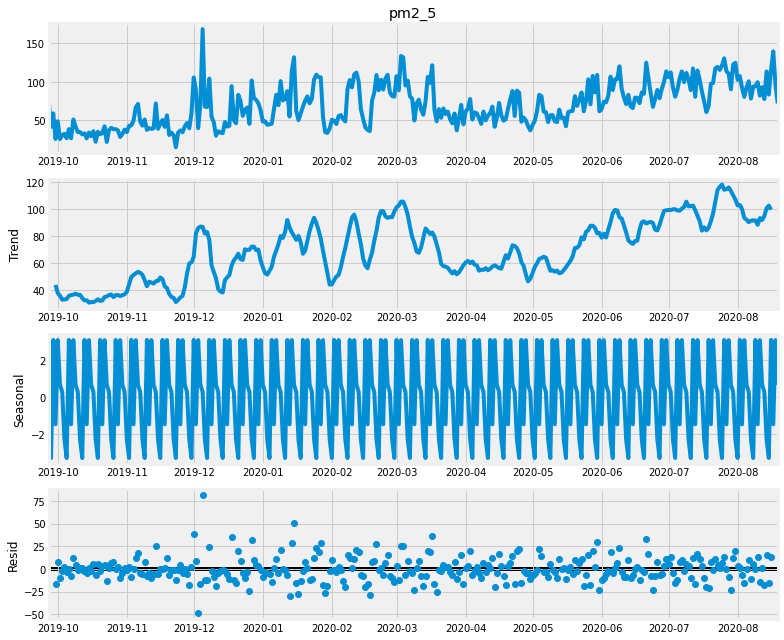

In [34]:
# add_cols
time_ser = train.loc[train.site_latitude == a[0]].sort_values(by = 'date')
time_ser.index = time_ser.date
time_ser = time_ser['pm2_5']
rcParams['figure.figsize'] = 11, 9
decomposed_google_volume = sm.tsa.seasonal_decompose(time_ser) # The frequncy is annual
figure = decomposed_google_volume.plot()
plt.show()

In [37]:
adf = adfuller(np.log(time_ser))
print("p-value of pm2_5: {}".format(float(adf[1])))

p-value of pm2_5: 0.30417722043902473


<AxesSubplot:xlabel='date'>

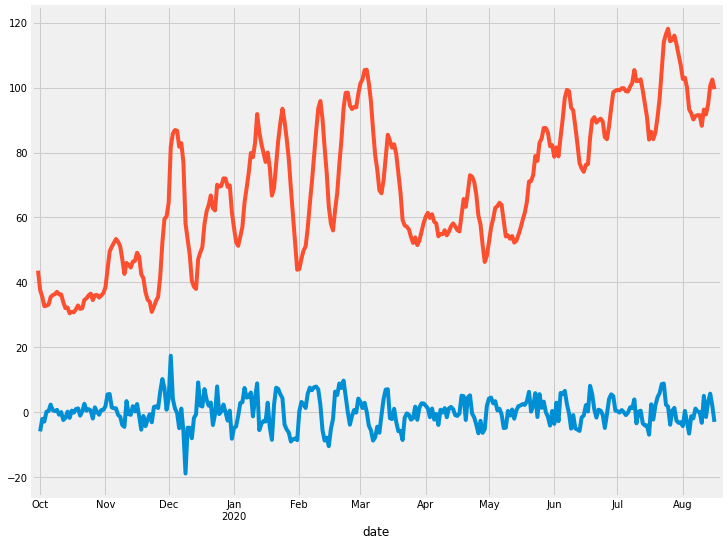

In [39]:
# decomposed_google_volume.trend.diff().plot()
# decomposed_google_volume.trend.plot()


In [11]:
drop_cols = ['ID','date','Train','pm2_5']#,'shifted_1',
#             'month', 'year', 'day',
#        'week', 'dow', 'woy',
#              'shifted_1', 'site_latitudepm2_5enc7',
#        'site_latitudepm2_5enc8', 'site_latitudepm2_5enc6',
#        'site_latitudepm2_5enc5', 'site_latitudepm2_5enc4',
#        'site_latitudepm2_5enc', 'site_latitudepm2_5enc1',
#        'site_latitudepm2_5enc2', 'site_latitudepm2_5enc3']
drop_cols2 = ['ID','date','shifted_1',
            'month', 'year', 'day',
       'week', 'dow', 'woy', 'shifted_1', 'site_latitudepm2_5enc7',
       'site_latitudepm2_5enc8', 'site_latitudepm2_5enc6',
       'site_latitudepm2_5enc5', 'site_latitudepm2_5enc4',
       'site_latitudepm2_5enc', 'site_latitudepm2_5enc1',
       'site_latitudepm2_5enc2', 'site_latitudepm2_5enc3']

In [12]:
y = train['pm2_5']

In [13]:

SEED = 42
NUM_CLASSES = 3
EARLY_STOPPING_ROUNDS = 30
N_ESTIMATORS = 1000
K_FOLDS = 2
# Define Parameters for LGBM
lgb_params = {
    "objective": "regression",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
#     "num_class": NUM_CLASSES,
    "num_leaves": 23,
#     "tree_learner": "feature",
    "n_jobs": 4,
    "seed": SEED,
    "max_depth": -1,
#     "max_bin": 255,
#     'reg_lambda': 0.1,  # L1 regularization term on weights
#     'reg_lambda': 1,
    "metric": "mae",
    "verbose": -1,
}
y_predicted_lgb,models_lgb,y_oof_lgb,oof_score_lgb,features_importance_lgb = train_lgb(train.drop([d for d in drop_cols if d in train.columns],axis = 1),
                                                                                       y,test.drop([d for d in drop_cols if d in test.columns],axis = 1),
                                                                                       lgb_params,None,False)

Shape of train_X : (9923, 74), test_X: (4254, 74), train_Y: (9923,)
fold 1 of 2
Training until validation scores don't improve for 30 rounds
[100]	training's l1: 14.8881	valid_1's l1: 14.7295
[200]	training's l1: 12.033	valid_1's l1: 12.3141
[300]	training's l1: 10.3033	valid_1's l1: 10.926
[400]	training's l1: 9.23832	valid_1's l1: 10.1465
[500]	training's l1: 8.472	valid_1's l1: 9.63685
[600]	training's l1: 7.86499	valid_1's l1: 9.24288
[700]	training's l1: 7.36601	valid_1's l1: 8.95733
[800]	training's l1: 6.97384	valid_1's l1: 8.75497
[900]	training's l1: 6.64497	valid_1's l1: 8.6097
[1000]	training's l1: 6.36846	valid_1's l1: 8.5006
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 6.36846	valid_1's l1: 8.5006
Best number of iterations for fold 1 is: 1000
CV OOF Score for fold 1 is 8.50060042250941
fold 2 of 2
Training until validation scores don't improve for 30 rounds
[100]	training's l1: 14.6686	valid_1's l1: 15.622
[200]	training's l1: 11.9526	valid_1's l1:

In [28]:
from catboost import Pool, CatBoostRegressor
params_cat = {'iterations':1500,
        'learning_rate':0.01,
        'random_strength':0.1,
        'depth':8,
        'loss_function':'RMSE',
        'eval_metric':'MAE',
        'verbose' : 100,
        'leaf_estimation_method':'Newton'}
y_predicted_cat,models_cat,y_oof_cat,oof_score_cat =train_catbo(train.drop([d for d in drop_cols if d in train.columns] +['preds'],axis = 1),
                                                                        y,test.drop([d for d in drop_cols if d in test.columns],axis = 1),params_cat,
                                                                seed_cat = None, shuffle_cat = False)

fold 1 of 2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 21.3083377	test: 20.7539453	best: 20.7539453 (0)	total: 50.8ms	remaining: 1m 16s
100:	learn: 15.3315330	test: 15.1503351	best: 15.1503351 (100)	total: 3.25s	remaining: 45s
200:	learn: 12.8201193	test: 12.9614455	best: 12.9614455 (200)	total: 6.35s	remaining: 41.1s
300:	learn: 11.1848137	test: 11.6317141	best: 11.6317141 (300)	total: 9.39s	remaining: 37.4s
400:	learn: 10.1342622	test: 10.8189637	best: 10.8189637 (400)	total: 12.5s	remaining: 34.2s
500:	learn: 9.3802585	test: 10.2489178	best: 10.2489178 (500)	total: 15.7s	remaining: 31.4s
600:	learn: 8.8053585	test: 9.8211540	best: 9.8211540 (600)	total: 19.3s	remaining: 28.9s
700:	learn: 8.3407560	test: 9.5031797	best: 9.5031797 (700)	total: 22.4s	remaining: 25.6s
800:	learn: 7.9580044	test: 9.2615283	best: 9.2615283 (800)	total: 25.6s	remaining: 22.3s
900:	learn: 7.6154399	test: 9.0556622	best: 9.0556622 (900)	total: 28.6s	remaining: 19s
1000:	learn: 7.3512588	test: 8.9099773	best: 8.9099773 (1000)	total: 31.8s	remaining: 15.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 20.6605285	test: 21.2270370	best: 21.2270370 (0)	total: 51.9ms	remaining: 1m 17s
100:	learn: 14.9725174	test: 15.7713317	best: 15.7713317 (100)	total: 3.19s	remaining: 44.2s
200:	learn: 12.6813047	test: 13.6552631	best: 13.6552631 (200)	total: 6.28s	remaining: 40.6s
300:	learn: 11.1272640	test: 12.2212070	best: 12.2212070 (300)	total: 9.44s	remaining: 37.6s
400:	learn: 10.1678639	test: 11.4082380	best: 11.4082380 (400)	total: 12.5s	remaining: 34.3s
500:	learn: 9.5136238	test: 10.8946104	best: 10.8946104 (500)	total: 15.6s	remaining: 31.1s
600:	learn: 8.9902546	test: 10.4985165	best: 10.4985165 (600)	total: 18.7s	remaining: 28s
700:	learn: 8.5283895	test: 10.1618811	best: 10.1618811 (700)	total: 21.9s	remaining: 24.9s
800:	learn: 8.1700891	test: 9.9187602	best: 9.9187602 (800)	total: 25s	remaining: 21.8s
900:	learn: 7.8503953	test: 9.7161322	best: 9.7161322 (900)	total: 28.1s	remaining: 18.7s
1000:	learn: 7.5601310	test: 9.5290202	best: 9.5290202 (1000)	total: 31.6s	remaining:

In [29]:
# anal(4,y_predicted_lgb,y_oof_lgb)
preds_to_sub(test,y_predicted_cat,'2_1')

,ID,pm2_5
0,ID_UOH62J0XHX,35.950717
1,ID_4OPWSB0UHJ,101.158547
2,ID_3SLMNNG1Z3,58.378629
3,ID_MFUHTXYPM4,75.130562
4,ID_TY1DAND8ZP,79.371363
...,...,...
4249,ID_NYKGOYFBKZ,55.581213
4250,ID_IWO4EVLHSQ,80.912718
4251,ID_G1M1IMY9WU,60.035352
4252,ID_DXV65Q1QXI,62.195857


In [36]:
params_xgb = {"objective":"reg:squarederror",'learning_rate': 0.01,
           'max_depth': 3}#, 'subsample': 0.9,
#           'colsample_bytree': 0.9}

y_predicted_xgb,models_xgb,y_oof_xgb,oof_score_xgb=train_xgb(train.drop([d for d in drop_cols if d in train.columns] +['preds'],axis = 1),
                                                                        y,test.drop([d for d in drop_cols if d in test.columns],axis = 1),
                                                             params_xgb,num_iter=1500,es = 30,ve = 100)

 xgb kfold: 1  of  2 : 
[0]	train-rmse:62.61696	valid-rmse:62.16344
[100]	train-rmse:31.34074	valid-rmse:30.68972
[200]	train-rmse:22.73346	valid-rmse:22.19172
[300]	train-rmse:20.02958	valid-rmse:19.83606
[400]	train-rmse:18.63138	valid-rmse:18.83246
[500]	train-rmse:17.75976	valid-rmse:18.34904
[600]	train-rmse:17.18867	valid-rmse:18.20420
[700]	train-rmse:16.73907	valid-rmse:18.01011
[800]	train-rmse:16.25900	valid-rmse:17.80850
[900]	train-rmse:15.87360	valid-rmse:17.65587
[1000]	train-rmse:15.54064	valid-rmse:17.50005
[1100]	train-rmse:15.25534	valid-rmse:17.33949
[1200]	train-rmse:14.99026	valid-rmse:17.20016
[1300]	train-rmse:14.77408	valid-rmse:17.08532
[1400]	train-rmse:14.56278	valid-rmse:16.96202
[1499]	train-rmse:14.37010	valid-rmse:16.84481
CV OOF Score for fold 1 is 11.206561497595931
 xgb kfold: 2  of  2 : 
[0]	train-rmse:62.15980	valid-rmse:62.61810
[100]	train-rmse:30.46033	valid-rmse:31.56559
[200]	train-rmse:21.48638	valid-rmse:23.08446
[300]	train-rmse:18.59410	vali

In [37]:
preds_to_sub(test,y_predicted_xgb,'2_24')

,ID,pm2_5
0,ID_UOH62J0XHX,32.943779
1,ID_4OPWSB0UHJ,89.505508
2,ID_3SLMNNG1Z3,58.378643
3,ID_MFUHTXYPM4,73.569592
4,ID_TY1DAND8ZP,75.949150
...,...,...
4249,ID_NYKGOYFBKZ,51.092180
4250,ID_IWO4EVLHSQ,70.609810
4251,ID_G1M1IMY9WU,55.635771
4252,ID_DXV65Q1QXI,62.009933


Feature        object
Importance    float64
dtype: object


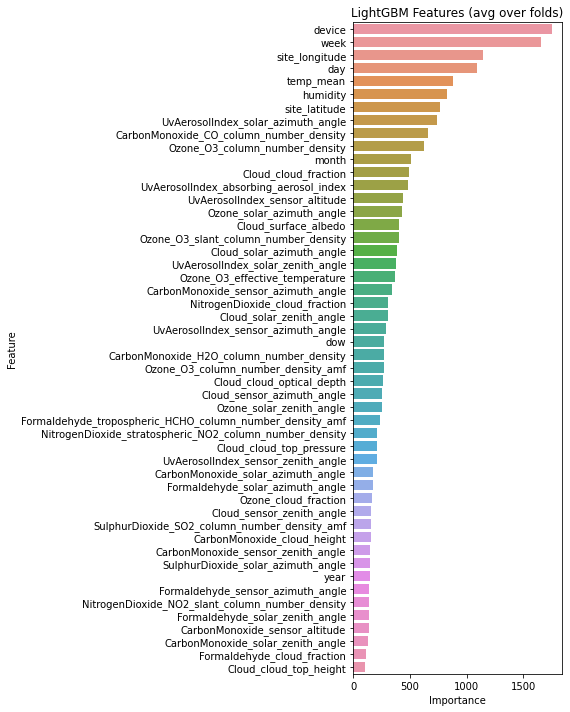

In [14]:
display_importances(features_importance_lgb)

In [15]:
# plt.pl
train['preds'] = y_oof_lgb

In [16]:
a = train.site_latitude.unique()
# train.reset_index(drop = True, inplace = True)

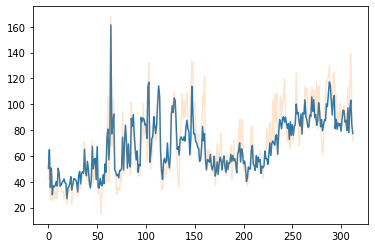

In [17]:
plt.plot(train.groupby('site_latitude').get_group(a[0]).sort_values(by = 'date')['preds'].values)
plt.plot(train.groupby('site_latitude').get_group(a[0]).sort_values(by = 'date')['pm2_5'].values,alpha = 0.2)
# train

In [50]:
# train['errors'] = train['preds'] - train['pm2_5']
(train.date.max()- train.date.min()).days

525

In [125]:
# train.drop(drop_cols2, axis = 1)[abs(train['preds'] - train['pm2_5'])>15].corr()['pm2_5'].sort_values(ascending = False, key = abs)


In [126]:
X_

array([ 0.35346,  0.39074,  0.28575, -1.24498,  0.3564 ,  0.30758,
        0.34373,  0.39148,  0.31545,  0.37956,  0.30667,  0.34701,
        0.38158,  0.0596 ,  0.35799,  0.3075 ,  0.2866 ,  0.31997,
        0.3101 ,  0.3439 ,  0.29875,  0.37308,  0.28368,  0.26501,
        0.30749,  0.36075,  0.28904,  0.2182 ,  0.30778,  0.35482,
        0.344  ,  0.3547 ,  0.3517 ,  0.36021])

In [138]:
# X_train = train.loc[(train.site_laritude == a[0])]
# lr.fit()
def get_train_val(train,test_size,group):
    temp = train.loc[(train.site_latitude == group)]
    X_train = temp.loc[temp.date < temp.date.min() + (1-test_size)*(temp.date.max()-temp.date.min()) ]
    X_val = temp.loc[temp.date >= temp.date.min() + (1-test_size)*(temp.date.max()-temp.date.min())]
    return X_train, X_val

In [140]:
from sklearn.metrics import mean_absolute_error as mae

In [67]:
def fit_line(group,test_size):
    X_train, X_val = get_train_val(train.fillna(0),test_size,group)
    lr = LinearRegression()
    lr.fit(X_train.drop(drop_cols, axis = 1),np.log(X_train['pm2_5']))
    preds = np.exp(lr.predict(X_val.drop(drop_cols, axis = 1)))
    plt.plot(X_val['pm2_5'].values,label = 'True')
    plt.plot(preds,label = 'preds')
    plt.axhline(y = X_train['pm2_5'].mean())
    plt.legend()
    plt.show()
    print(mae(X_val['pm2_5'],preds))

In [68]:
fit_line(group = a[2],test_size = 0.1)


NameError: name 'a' is not defined

In [18]:
def anal(i,preds,y_oof,log = False):
    if log:
        test['pm2_5'] = np.exp(preds)
    else:
        test['pm2_5'] = preds

    all_data = pd.concat([train,test])
    a = all_data.groupby('site_latitude').get_group(all_data.site_latitude.unique()[i])[['date','pm2_5','Train']]
    y1 = a.loc[a.Train == 1].sort_values(by = 'date')['pm2_5'].values
    y2 = a.loc[a.Train == 0].sort_values(by = 'date')['pm2_5'].values
    x1 = range(len(y1))
    x2 = range(len(y1),len(y1)+len(y2))
    if log :
        y3 = np.exp(y_oof[a.loc[a.Train == 1].index])
    else:
        y3 = y_oof[a.loc[a.Train == 1].index]
    plt.plot(x1,y1,label = 'true')
    plt.plot(x1,y3)
    plt.plot(x2,y2)
    

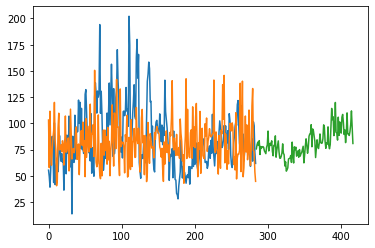

In [23]:
# anal(1,y_predicted_cat)
# anal(7,y_predicted_lgb,y_oof_lgb)
# test.groupby('site_code')

# sns.distplot(test['pm2_5'])

# sns.distplot(train['pm2_5'])
# train.groupby('site_latitude')['site_longitude'].unique()
# train.groupby('site_code').apply(lambda )
# train.index = train.date

,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5,Train,month,year,day,week,dow,woy,rel_date,site_code,preds
0,16.0,-1.24498,29.98924,0.991833,14.058333,-1.675318e-04,1.439262,-2.411221e-04,0.229150,-100.536606,29.266684,-70.037514,27.477388,-1.098045e-04,0.029542,1769.049974,1303.112997,830040.675191,-98.162869,29.224369,-70.002930,27.481755,0.000041,0.000008,0.000033,0.000087,8613.273041,-1.186050,0.146440,830062.0000,-100.536606,29.266684,-70.037514,27.477388,0.000131,2.286472,0.000229,0.229150,27.477388,-70.037514,29.266684,-100.536606,-1.186078,830062.000000,-100.536606,29.266684,-70.037514,27.477388,0.120523,2.282657,0.279412,229.614334,0.234132,-100.536606,29.266684,-70.037514,27.477388,0.234335,68520.523438,3304.507812,77259.148438,2304.507812,10.194275,0.373142,-100.536613,29.266832,-70.037529,27.477406,50.216700,1.0,4.0,2019.0,10.0,15.0,2.0,15.0,318.0,0.0,45.795564
1,16.0,-1.24498,29.98924,0.948075,15.296250,-8.343319e-05,1.159798,-1.202682e-04,0.202037,-13.300415,35.567424,-64.501335,23.438059,-5.477291e-05,0.028245,2147.631921,2548.658183,829861.118845,-13.049147,35.485199,-64.542490,23.455099,0.000043,0.000010,0.000033,0.000092,8613.274881,-1.892071,0.128259,829885.0000,-13.300415,35.567424,-64.501335,23.438059,0.000087,1.756909,0.000102,0.202037,23.438059,-64.501335,35.567424,-13.300415,-1.892084,829885.000000,-13.300415,35.567424,-64.501335,23.438059,0.121540,2.343575,0.290115,227.460030,0.206429,-13.300415,35.567424,-64.501335,23.438059,0.206576,55601.111328,5176.206543,62942.117188,4176.206543,8.364834,0.342693,-13.300426,35.567420,-64.501373,23.438078,89.827710,1.0,4.0,2019.0,11.0,15.0,3.0,15.0,338.0,0.0,41.494419
2,16.0,-1.24498,29.98924,0.904317,16.534167,6.654166e-07,0.880334,5.857885e-07,0.174923,73.935776,41.868164,-58.965157,19.398729,2.587009e-07,0.026948,2526.2138

In [410]:
# df.select_dtypes(exclude ='object')
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
imputer.fit_transform(df.drop('date',axis = 1).values)


array([[ 1.60000000e+01, -1.24498000e+00,  2.99892400e+01, ...,
         1.50000000e+01,  3.18000000e+02,  0.00000000e+00],
       [ 1.48409755e+01,  2.42511714e-01,  3.24720127e+01, ...,
         2.53337700e+01,  2.44951023e+02,  1.55819813e+01],
       [ 1.60000000e+01, -1.24498000e+00,  2.99892400e+01, ...,
         1.50000000e+01,  3.58000000e+02,  0.00000000e+00],
       ...,
       [ 2.90000000e+01,  3.91480000e-01,  3.26258300e+01, ...,
         3.40000000e+01,  4.49000000e+02,  3.40000000e+01],
       [ 2.90000000e+01,  3.91480000e-01,  3.26258300e+01, ...,
         3.40000000e+01,  3.01000000e+02,  3.40000000e+01],
       [ 2.90000000e+01,  3.91480000e-01,  3.26258300e+01, ...,
         3.40000000e+01,  2.00000000e+01,  3.40000000e+01]])

In [388]:
test.index = test.date

In [389]:
test.sort_index().groupby('site_code').resample('D').mean().shape

(4433, 78)

In [390]:
test.shape

(4254, 80)

,ID,pm2_5
0,ID_UOH62J0XHX,30.594022
1,ID_4OPWSB0UHJ,119.928220
2,ID_3SLMNNG1Z3,58.135105
3,ID_MFUHTXYPM4,71.202621
4,ID_TY1DAND8ZP,78.948920
...,...,...
4249,ID_NYKGOYFBKZ,54.976234
4250,ID_IWO4EVLHSQ,79.446282
4251,ID_G1M1IMY9WU,58.147766
4252,ID_DXV65Q1QXI,64.442309


In [48]:
sub

,ID,pm2_5
0,ID_UOH62J0XHX,35.932458
1,ID_4OPWSB0UHJ,115.519109
2,ID_3SLMNNG1Z3,60.979665
3,ID_MFUHTXYPM4,68.402457
4,ID_TY1DAND8ZP,93.404562
...,...,...
4249,ID_NYKGOYFBKZ,55.473415
4250,ID_IWO4EVLHSQ,85.472135
4251,ID_G1M1IMY9WU,62.928728
4252,ID_DXV65Q1QXI,66.639720


In [49]:
sub.to_csv('lgb_5.csv',index = False)

In [60]:
from catboost import Pool, CatBoostRegressor
params_cat = {'iterations':1500,
        'learning_rate':0.01,
        'random_strength':0.1,
        'depth':8,
        'loss_function':'MAE',
        'eval_metric':'MAE',
        'verbose' : 100}
y_predicted_cat,models_cat,y_oof_cat,oof_score_cat =train_catbo(train.drop(drop_cols,axis = 1),
                                                                y,test.drop(drop_cols,axis = 1),params_cat,42,
                                                               True)

fold 1 of 5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 20.6804579	test: 20.2497931	best: 20.2497931 (0)	total: 53.9ms	remaining: 1m 20s
100:	learn: 13.9973480	test: 13.7554360	best: 13.7554360 (100)	total: 3.41s	remaining: 47.3s
200:	learn: 11.5570069	test: 11.6081269	best: 11.6081269 (200)	total: 6.82s	remaining: 44.1s
300:	learn: 10.3208751	test: 10.5304648	best: 10.5304648 (300)	total: 10.1s	remaining: 40.4s
400:	learn: 9.4674735	test: 9.8269943	best: 9.8269943 (400)	total: 13.4s	remaining: 36.9s
500:	learn: 8.7961507	test: 9.2958582	best: 9.2958582 (500)	total: 16.8s	remaining: 33.4s
600:	learn: 8.2715720	test: 8.8973706	best: 8.8973706 (600)	total: 20.4s	remaining: 30.6s
700:	learn: 7.8072021	test: 8.5434350	best: 8.5434350 (700)	total: 23.9s	remaining: 27.2s
800:	learn: 7.4354522	test: 8.2816883	best: 8.2816883 (800)	total: 28s	remaining: 24.5s
900:	learn: 7.1137646	test: 8.0548005	best: 8.0548005 (900)	total: 31.5s	remaining: 21s
1000:	learn: 6.8496607	test: 7.8987368	best: 7.8987368 (1000)	total: 34.9s	remaining: 17.4s
11

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 20.6943234	test: 20.2216891	best: 20.2216891 (0)	total: 54.6ms	remaining: 1m 21s
100:	learn: 14.1080265	test: 13.6979842	best: 13.6979842 (100)	total: 3.68s	remaining: 50.9s
200:	learn: 11.6351672	test: 11.4593645	best: 11.4593645 (200)	total: 7.12s	remaining: 46s
300:	learn: 10.4398678	test: 10.4655341	best: 10.4655341 (300)	total: 10.5s	remaining: 41.8s
400:	learn: 9.5655546	test: 9.8089559	best: 9.8089559 (400)	total: 13.8s	remaining: 37.9s
500:	learn: 8.8903684	test: 9.3050570	best: 9.3050570 (500)	total: 17.2s	remaining: 34.3s
600:	learn: 8.3463844	test: 8.9023089	best: 8.9023089 (600)	total: 20.6s	remaining: 30.8s
700:	learn: 7.8725927	test: 8.5484806	best: 8.5484806 (700)	total: 23.9s	remaining: 27.3s
800:	learn: 7.4946690	test: 8.2783577	best: 8.2783577 (800)	total: 27.7s	remaining: 24.2s
900:	learn: 7.1727709	test: 8.0781945	best: 8.0781945 (900)	total: 31.2s	remaining: 20.7s
1000:	learn: 6.8766398	test: 7.9013005	best: 7.9013005 (1000)	total: 34.9s	remaining: 17.4s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 20.6022263	test: 20.5568725	best: 20.5568725 (0)	total: 53.8ms	remaining: 1m 20s
100:	learn: 13.8699374	test: 13.9449894	best: 13.9449894 (100)	total: 3.68s	remaining: 51s
200:	learn: 11.4437029	test: 11.8393031	best: 11.8393031 (200)	total: 7.02s	remaining: 45.4s
300:	learn: 10.2074288	test: 10.7972189	best: 10.7972189 (300)	total: 10.4s	remaining: 41.4s
400:	learn: 9.3568074	test: 10.1275683	best: 10.1275683 (400)	total: 14.1s	remaining: 38.6s
500:	learn: 8.7161984	test: 9.6324848	best: 9.6324848 (500)	total: 17.4s	remaining: 34.6s
600:	learn: 8.2072002	test: 9.2702798	best: 9.2702798 (600)	total: 20.7s	remaining: 31s
700:	learn: 7.7739017	test: 8.9682680	best: 8.9682680 (700)	total: 24.1s	remaining: 27.5s
800:	learn: 7.4044723	test: 8.7111698	best: 8.7111698 (800)	total: 27.4s	remaining: 23.9s
900:	learn: 7.0967443	test: 8.5202318	best: 8.5202318 (900)	total: 30.8s	remaining: 20.5s
1000:	learn: 6.8346659	test: 8.3640678	best: 8.3640678 (1000)	total: 34.8s	remaining: 17.4s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 20.6126207	test: 20.5124201	best: 20.5124201 (0)	total: 52.1ms	remaining: 1m 18s
100:	learn: 13.9168300	test: 14.4653887	best: 14.4653887 (100)	total: 3.38s	remaining: 46.8s
200:	learn: 11.5004732	test: 12.3066641	best: 12.3066641 (200)	total: 6.71s	remaining: 43.3s
300:	learn: 10.2652195	test: 11.1813590	best: 11.1813590 (300)	total: 10s	remaining: 39.9s
400:	learn: 9.4536080	test: 10.4616411	best: 10.4616411 (400)	total: 13.4s	remaining: 36.6s
500:	learn: 8.8134786	test: 9.9142701	best: 9.9142701 (500)	total: 16.7s	remaining: 33.3s
600:	learn: 8.2952283	test: 9.4934253	best: 9.4934253 (600)	total: 20s	remaining: 29.9s
700:	learn: 7.8539801	test: 9.1634367	best: 9.1634367 (700)	total: 24.1s	remaining: 27.4s
800:	learn: 7.4879989	test: 8.8795040	best: 8.8795040 (800)	total: 27.4s	remaining: 23.9s
900:	learn: 7.1503085	test: 8.6423372	best: 8.6423372 (900)	total: 30.8s	remaining: 20.4s
1000:	learn: 6.8716627	test: 8.4654100	best: 8.4654100 (1000)	total: 34.1s	remaining: 17s
11

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 20.3857817	test: 21.4519407	best: 21.4519407 (0)	total: 55.5ms	remaining: 1m 23s
100:	learn: 13.7530353	test: 15.0019131	best: 15.0019131 (100)	total: 3.78s	remaining: 52.4s
200:	learn: 11.3516368	test: 12.8038341	best: 12.8038341 (200)	total: 7.09s	remaining: 45.8s
300:	learn: 10.0630382	test: 11.6527315	best: 11.6527315 (300)	total: 10.4s	remaining: 41.4s
400:	learn: 9.2910583	test: 10.9796413	best: 10.9796413 (400)	total: 13.8s	remaining: 37.7s
500:	learn: 8.6264632	test: 10.4434483	best: 10.4434483 (500)	total: 17.1s	remaining: 34.1s
600:	learn: 8.0618670	test: 9.9956663	best: 9.9956663 (600)	total: 20.5s	remaining: 30.6s
700:	learn: 7.6273096	test: 9.6697939	best: 9.6697939 (700)	total: 23.9s	remaining: 27.2s
800:	learn: 7.2734446	test: 9.4375479	best: 9.4375479 (800)	total: 27.2s	remaining: 23.8s
900:	learn: 6.9482909	test: 9.2128718	best: 9.2128718 (900)	total: 30.6s	remaining: 20.3s
1000:	learn: 6.6709924	test: 9.0235139	best: 9.0235139 (1000)	total: 34.3s	remaining: 